#### Insatll libs

In [ ]:
# pip install fuzzywuzzy
# pip install python-Levenshtein

#### Import necessary libs

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import warnings
warnings.filterwarnings('ignore')

#### Read csv data

In [73]:
df = pd.read_csv("exploratory_data_analysis_dataset_1.csv")

In [74]:
df.head()

,txnId,transactionTimestamp,valueDate,narration,type,mode,currentBalance,amount,reference
0,M12460134,2021-01-04T00:00:00+05:30,2021-01-04,UPI/100304559280/Oid100002510080/paytm-irctcap...,DEBIT,UPI,440609.832,262.080,RF11015412
1,M12470135,2021-01-04T00:00:00+05:30,2021-01-04,UPI/100437751856/collect/paytm-irctcapp@/Paytm...,CREDIT,UPI,441417.912,808.080,RF12015413
2,M12480136,2021-01-07T00:00:00+05:30,2021-01-07,UPI/100712222548/Skinethics/gpay-1116488882/Ax...,DEBIT,UPI,441117.912,300.000,RF13015414
3,M12490137,2021-01-08T00:00:00+05:30,2021-01-08,UPI/100806142513/Oid100002517246/paytm-irctcap...,DEBIT,UPI,440798.538,319.374,RF14015415
4,M12500138,2021-01-08T00:00:00+05:30,2021-01-08,UPI/100816392006/Pay To RAY OF J/bharatpe.9050...,DEBIT,UPI,439598.538,1200.000,RF15015416


### 1) number of rows in dataset

In [75]:
# number of rows in dataset
msg = f'''Bank transaction dataset consists of {len(df)} rows.'''
print(msg)

Bank transaction dataset consists of 465 rows.


### 2) Find missing value if there

In [76]:
# Find missing value
df.isnull().sum()

txnId                   0
transactionTimestamp    0
valueDate               0
narration               0
type                    0
mode                    0
currentBalance          0
amount                  0
reference               0
dtype: int64

#### There is no missing value present in data

### 3) Here we are calculating outlier to identify fraudulent transection
#### Assumption: 
-  If amount is debited more than 75% of the total balance then we can say it as a fraudulent transection

In [77]:
# We'll find outlier using IQR
df_bedit = df[df['type']=="DEBIT"]

# Find 25% and 75% of data
Q1 = np.percentile(df_bedit['amount'], 25)
Q3 = np.percentile(df_bedit['amount'], 75)

# Calculate IQR
IQR = Q3 - Q1

In [78]:
# Find upper and lower bound
ul = Q3+1.5*IQR
ll = Q1-1.5*IQR

In [79]:
# In roder to find outlier we'll take >upper limit
df_debit = df_bedit[(df_bedit['amount']>ul)]
df_debit.head()

,txnId,transactionTimestamp,valueDate,narration,type,mode,currentBalance,amount,reference
10,M12560144,2021-01-13T00:00:00+05:30,2021-01-13,MMT/IMPS/101315098813/Farm loan repay/ND A/S,DEBIT,OTHERS,600087.738,108000.0,RF21015422
55,M13010189,2021-03-01T00:00:00+05:30,2021-03-01,CLG/LIFE INSURANCE CORPORATIO ...,DEBIT,OTHERS,816562.032,44336.4,RF66015467
58,M13040192,2021-03-02T00:00:00+05:30,2021-03-02,BIL/ONL/000057164189/CRED CLUB/DP-6RaG1PayN5xl...,DEBIT,OTHERS,779548.032,35787.6,RF69015470
62,M13080196,2021-03-08T00:00:00+05:30,2021-03-08,BIL/INFT/000062173555/Flat/ ...,DEBIT,OTHERS,537366.432,240000.0,RF73015474
72,M13180206,2021-03-09T00:00:00+05:30,2021-03-09,BIL/NEFT/000064221973/Home Down Payme/RAJENDRA...,DEBIT,OTHERS,422213.472,120000.0,RF83015484


In [80]:
# Here we'll find how many percentage amount is debited from account, if it is more than 75% then we'll consider it as a fraud transection
df_debit['percentage'] = (df_debit["amount"] * 100) // (df_debit["amount"]+df_debit["currentBalance"])
df_fraud = df_debit[df_debit['percentage'].astype('int')>75]
df_fraud

,txnId,transactionTimestamp,valueDate,narration,type,mode,currentBalance,amount,reference,percentage
105,M13510239,2021-03-15T00:00:00+05:30,2021-03-15,BIL/NEFT/000068523876/StampDutyDHCFee/AJINKYA ...,DEBIT,OTHERS,2902.584,313560.0,RF116015517,99.0
111,M13570245,2021-03-19T00:00:00+05:30,2021-03-19,BIL/INFT/000071260159/Return/ ...,DEBIT,OTHERS,18843.126,120000.0,RF122015523,86.0
365,M16110499,2021-10-07T00:00:00+05:30,2021-10-07,BIL/INFT/000226758955/Share Transfer/ ...,DEBIT,OTHERS,14248.866,66150.0,RF376015777,82.0
391,M16370525,2021-11-05T00:00:00+05:30,2021-11-05,MMT/IMPS/130912752020/Gattu Fees/SVKM NMIMS/KK...,DEBIT,OTHERS,62597.790,204900.0,RF402015803,76.0


#### we are getting 4 fraudulent transections

### 4) Now we are going to check different payment methods used and how many time they used while transection

In [93]:
transection_mode = df['mode'].value_counts()
modes = transection_mode.keys()
for mode in modes:
    msg = f''' {mode} has total {transection_mode[mode]} transections '''
    print(msg)

 UPI has total 308 transections 
 OTHERS has total 108 transections 
 FT has total 49 transections 


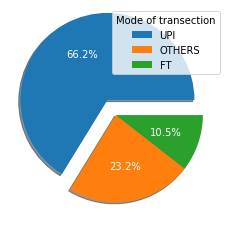

In [98]:
# Lets see same in graphical manner
y = transection_mode.values
mylabels = transection_mode.keys()
myexplode = [0.2, 0, 0]

plt.pie(y, labels = mylabels, autopct='%1.1f%%', explode = myexplode, shadow = True, textprops={'color':"w"})
plt.legend(title = "Mode of transection")
plt.show() 
plt.show() 

#### Here as we can see that UPI has max uses while FT has min uses

### 5) Now we are grouping the similar transactions id based on similar narration
#### Assumption
- Lets assume threshold value 80
- if similarity_count > 80 then we'll assume that narration as a smiliar otherwise different

In [234]:
index = list()
narration = list()
similar_narration = list()
amount = list()
txnId = list()
for i in df.index:
    for j in df.index:
        if fuzz.ratio(df['narration'][i],df['narration'][j]) > 80: 
            index.append(i)
            narration.append(df['narration'][i])
            similar_narration.append(df['narration'][j])
            amount.append(df['amount'][j])
            txnId.append(df['txnId'][j])

In [235]:
new_df = pd.DataFrame({'index':index, 'txnId':txnId, 'narration':narration, 'similar_narration':similar_narration, 'amount':amount})

In [236]:
new_df

,index,txnId,narration,similar_narration,amount
0,0,M12460134,UPI/100304559280/Oid100002510080/paytm-irctcap...,UPI/100304559280/Oid100002510080/paytm-irctcap...,262.080
1,0,M12650153,UPI/100304559280/Oid100002510080/paytm-irctcap...,UPI/102567354483/Oid100002544108/paytm-irctcap...,698.160
2,0,M12730161,UPI/100304559280/Oid100002510080/paytm-irctcap...,UPI/103725588679/Oid100002563181/paytm-irctcap...,265.080
3,0,M12740162,UPI/100304559280/Oid100002510080/paytm-irctcap...,UPI/103725759682/Oid100002563181/paytm-irctcap...,61.080
4,0,M12860174,UPI/100304559280/Oid100002510080/paytm-irctcap...,UPI/104652586986/Oid100002581676/paytm-irctcap...,94.080
...,...,...,...,...,...
1170,463,M16320520,UPI/200212185648/payment on CRED/credclub@icic...,UPI/130566973258/payment on CRED/credclub@icic...,792.996
1171,463,M16720560,UPI/200212185648/payment on CRED/credclub@icic...,UPI/133509943006/payment on CRED/credclub@icic...,26461.800
1172,463,M16730561,UPI/200212185648/payment on CRED/credclub@icic...,UPI/133563620994/payment on CRED/credclub@icic...,6721.104
1173,463,M17090597,UPI/200212185648/payment on CRED/credclub@icic...,UPI/200212185648/payment on CRED/credclub@icic...,34125.396


In [248]:
new_df.groupby('index').agg({'amount':'sum','txnId':', '.join})

,amount,txnId
index,,
0,1380.480,"M12460134, M12650153, M12730161, M12740162, M1..."
1,826.080,"M12470135, M12880176"
2,300.000,M12480136
3,3236.934,"M12490137, M12860174, M13130201, M13140202, M1..."
4,1200.000,M12500138
...,...,...
460,30000.000,M17060594
461,180000.000,"M14000288, M17070595"
462,11166.000,M17080596


#### Based on fuzz logic we got similar narration and so similar transections id

### 6) Highest currentBalance and lowest currentBalance

In [264]:
msg = f''' Max available amount is {df['currentBalance'].max()} '''
print(msg)

 Max available amount is 1242372.78 


In [265]:
msg = f''' Max available amount is {df['currentBalance'].min()} '''
print(msg)

 Max available amount is 2902.584 


### 7) Highest and lowest amount debited

In [266]:
msg = f''' Max amount debited is {df[df['type']=='DEBIT']['amount'].max()} '''
print(msg)

 Max amount debited is 313560.0 


In [267]:
msg = f''' Min amount debited is {df[df['type']=='DEBIT']['amount'].min()} '''
print(msg)

 Min amount debited is 0.6 


### 8) Highest and lowest amount credited

In [262]:
msg = f''' Max amount credited is {df[df['type']=='CREDIT']['amount'].max()} '''
print(msg)

 Max amount credited is 990000.0 


In [263]:
msg = f''' Min amount credited is {df[df['type']=='CREDIT']['amount'].min()} '''
print(msg)

 Min amount credited is 0.6 
